In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import pickle
import dlib

In [2]:
def load_image_to_vector(image_path,image_number):
    img_data=[]
    for i in range (image_number):
        img_color= mpimg.imread(image_path + str(i) + '.jpg')
        img=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
        width=np.shape(img_color)[0]
        height=np.shape(img_color)[1]
        img_vector=img.reshape(width*height)
        img_data.append(img_vector)
    return img_data

In [3]:
def get_label(label_path,label_name):
    label=pd.read_table(label_path)
    y=label[label_name]
    return y

In [4]:
def SVM_model(x_train,y_train,x_test,y_test):
    clf=SVC(gamma='auto')
    clf.fit(x_train,y_train)
    y_pred =  clf.predict(x_test)
    print('Accuracy on train set:'+str(clf.score(x_train,y_train)))
    print('Accuracy on test set: '+str(accuracy_score(y_test,y_pred)))
    print(classification_report(y_test,y_pred))
    return clf

In [5]:
def img_data_pca(img_data,dimention):
    pca = PCA(n_components = 100)
    pca.fit(img_data)
    pca_data=pca.transform(img_data)
    return pca_data

In [11]:
def face_feature(img_path,img_number):
    predictor_path = "./shape_predictor_68_face_landmarks.dat"
    face_rec_model_path = "./dlib_face_recognition_resnet_model_v1.dat"
    detector = dlib.get_frontal_face_detector() #a detector to find the faces
    sp = dlib.shape_predictor(predictor_path ) #shape predictor to find face landmarks
    facerec = dlib.face_recognition_model_v1(face_rec_model_path) #face recognition model
    img_data=np.zeros((img_number,128))
    for i in range (img_number):
        img = dlib.load_rgb_image('../datasets/'+img_path+'/img/' + str(i) + '.jpg')
        dets = detector(img, 1)  #Extract the face area in the picture
        for k, d in enumerate(dets):
            shape = sp(img, d)
            face_descriptor = facerec.compute_face_descriptor(img, shape)
            img_data[i,:]=face_descriptor
    return img_data

In [7]:
def face_feature_read(csv_name):
    img_data = pd.read_csv('./'+csv_name+'.csv')
    img_data=np.array(img_data)
    img_data=img_data[:,1:]
    return img_data

In [8]:
def learn_curve(x_train,y_train,x_test,y_test):
    l2_iter = []
    l2_iter_t = []
    iters = np.arange(5000,10000,500)
    for i in iters:
        lr2 = SVC(gamma='auto',max_iter=i)
        lr2 = lr2.fit(x_train,y_train)
        l2_iter.append(accuracy_score(lr2.predict(x_train),y_train))
        l2_iter_t.append(accuracy_score(lr2.predict(x_test),y_test))
    plt.plot(figsize=(20,6))
    plt.plot(iters,l2_iter,label='accuracy')
    plt.plot(iters,l2_iter_t,label='val_accuracy')
    plt.xticks(iters)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [17]:
%%time
#Data without dimensionality reduction and feature extraction
#get image data
img_data=load_image_to_vector('../datasets/celeba/img/',5000)
#get label
label=get_label('../datasets/celeba/labels.csv','gender')
#Standardize the data
x_train, x_test, y_train, y_test = train_test_split(img_data, label,test_size=0.1,random_state=0)
transfer=StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)
#train the model and report accuracy
model=SVM_model(x_train,y_train,x_test,y_test)
#save model
pickle.dump(model,open("SVM_gender.dat","wb")) 

Accuracy on train set:0.9617777777777777
Accuracy on test set: 0.864
              precision    recall  f1-score   support

          -1       0.87      0.84      0.86       241
           1       0.86      0.88      0.87       259

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500

CPU times: total: 57min 36s
Wall time: 23min 38s


In [9]:
%%time
#Data with dimensionality reduction by PCA
#get image data
img_data=load_image_to_vector('../datasets/celeba/img/',5000)
#get label
label=get_label('../datasets/celeba/labels.csv','gender')
#pca for image data
x_train, x_test, y_train, y_test = train_test_split(img_data, label,test_size=0.1,random_state=0)
x_train=img_data_pca(x_train,100)
x_test=img_data_pca(x_test,100)
#Standardize the data
transfer=StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)
#train the model and report accuracy
model=SVM_model(x_train,y_train,x_test,y_test)
#save model
pickle.dump(model,open("SVM_gender_PCA.dat","wb")) 

Accuracy on train set:0.954
Accuracy on test set: 0.434
              precision    recall  f1-score   support

          -1       0.41      0.39      0.40       241
           1       0.46      0.48      0.47       259

    accuracy                           0.43       500
   macro avg       0.43      0.43      0.43       500
weighted avg       0.43      0.43      0.43       500

CPU times: total: 36.7 s
Wall time: 9.27 s


In [12]:
%%time
#Data with feature extraction
#img_data=face_feature_read('face_feature_train')
img_data=face_feature('celeba',5000)
#get label
label=get_label('../datasets/celeba/labels.csv','gender')
#Standardize the data
x_train, x_test, y_train, y_test = train_test_split(img_data, label,test_size=0.1,random_state=0)
transfer=StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)
#train the model and report accuracy
model=SVM_model(x_train,y_train,x_test,y_test)
#save model
pickle.dump(model,open("SVM_gender_dlib.dat","wb")) 

Accuracy on train set:0.9791111111111112
Accuracy on test set: 0.964
              precision    recall  f1-score   support

          -1       0.98      0.94      0.96       241
           1       0.95      0.98      0.97       259

    accuracy                           0.96       500
   macro avg       0.97      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

CPU times: total: 18min 9s
Wall time: 18min 17s


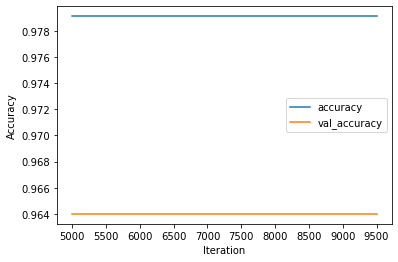

In [13]:
#learning_curve for LR
learn_curve(x_train,y_train,x_test,y_test)

In [ ]:
#The following is for testing 

In [14]:
%%time
##Data without dimensionality reduction and feature extraction
#get and preprocess image data for testing
img_data_test=load_image_to_vector('../datasets/celeba_test/img/',1000)
img_data_test = transfer.fit_transform(img_data_test)
#get label_test
label_test=get_label('../datasets/celeba_test/labels.csv','gender')
#load model
loaded_model = pickle.load(open("SVM_gender.dat","rb"))
label_pred=loaded_model.predict(img_data_test)
print('Accuracy on test set: '+str(accuracy_score(label_test,label_pred)))
print(classification_report(label_test,label_pred))

Accuracy on test set: 0.887
              precision    recall  f1-score   support

          -1       0.89      0.88      0.89       500
           1       0.88      0.89      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

CPU times: total: 5min 45s
Wall time: 2min 11s


In [15]:
%%time
#Data with dimensionality reduction by PCA
#get and preprocess image data for testing
img_data_test=load_image_to_vector('../datasets/celeba_test/img/',1000)
img_data_test = transfer.fit_transform(img_data_test )
#get label
label_test=get_label('../datasets/celeba_test/labels.csv','gender')
#pca for image data
img_data_test=img_data_pca(img_data_test,100)
#load model
loaded_model = pickle.load(open("SVM_gender_PCA.dat","rb"))
label_pred=loaded_model.predict(img_data_test)
print('Accuracy on test set: '+str(accuracy_score(label_test,label_pred)))
#print(classification_report(label_test,label_pred))

Accuracy on test set: 0.5
CPU times: total: 5.61 s
Wall time: 1.98 s


In [17]:
%%time
#Data with feature extraction
#get and preprocess image data for testing
#img_data_test=face_feature_read('face_feature_test')
img_data_test=face_feature('celeba_test',1000)
img_data_test = transfer.fit_transform(img_data_test )
#get label
label_test=get_label('../datasets/celeba_test/labels.csv','gender')
#load model
loaded_model = pickle.load(open("SVM_gender_dlib.dat","rb"))
label_pred=loaded_model.predict(img_data_test)
print('Accuracy on test set: '+str(accuracy_score(label_test,label_pred)))
print(classification_report(label_test,label_pred))

Accuracy on test set: 0.969
              precision    recall  f1-score   support

          -1       0.97      0.96      0.97       500
           1       0.96      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

CPU times: total: 3min 46s
Wall time: 3min 46s
